In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip -q install git+https://www.github.com/keras-team/keras-contrib.git 

In [ ]:
pip install tensorflow==1.13.1

In [ ]:
pip install keras==2.2.4

In [ ]:
import pandas as pd
import gensim
import keras as k
import matplotlib.pyplot as plt


import tensorflow as tf

import nltk
nltk.download('punkt')

from sklearn.model_selection import KFold, StratifiedKFold

from tensorflow import keras
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.optimizers import Adam, Nadam, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.models import load_model, model_from_json
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras.layers import Activation, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import plot_model
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from keras_contrib.layers import CRF
from keras_contrib.losses import  crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

!pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

global model, graph

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=2115e4a94ffd4be2da1a2f2b998bd8c4b667fabb96b7d5ec6e91b4f28c95359f
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
file_path = '/content/drive/My Drive/'

In [ ]:
data = pd.read_csv("/content/GABUNGAN15C.csv", encoding="utf-8")
data = data.fillna(method = "ffill")

In [ ]:
data["Tag"].value_counts()

O             171728
I-PURPOSE       2874
I-HERITAGE      2051
I-NATURAL       1853
B-PURPOSE       1811
B-NATURAL       1789
B-HERITAGE      1401
Name: Tag, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


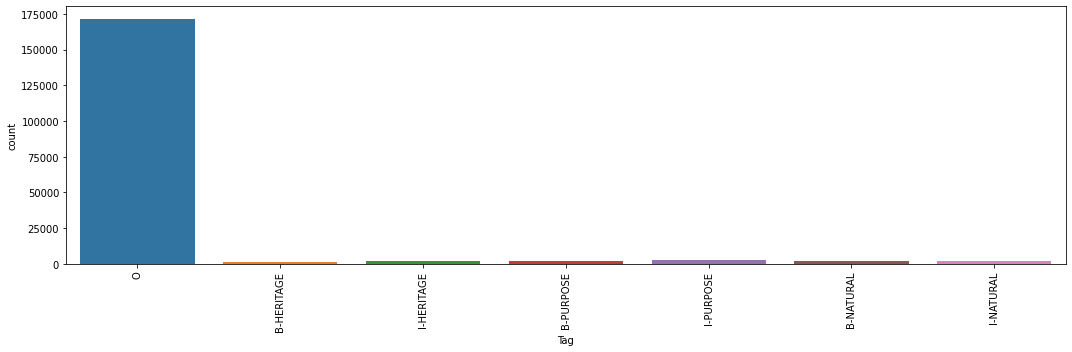

In [ ]:
import seaborn as sns
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Words"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

#get all the sentence
sentences = getter.sentences

words = sorted(set(data["Words"].values))
n_words = len(words); n_words
tags = sorted(set(data["Tag"].values))
n_tags = len(tags); n_tags

max_len = 90
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

from keras.preprocessing.sequence import pad_sequences

# pad the sequence
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# pad the target
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


[('There', 'O'), ("'", 'O'), ('s', 'O'), ('no', 'O'), ('denying', 'O'), ('it', 'O'), (',', 'O'), ('Budapest', 'O'), ('is', 'O'), ('one', 'O'), ('of', 'O'), ('Europe', 'O'), ("'", 'O'), ('s', 'O'), ('most', 'O'), ('underrated', 'O'), ('cities', 'O'), ('.', 'O')]


In [ ]:
dictionary = word2idx
np.save('ID_Dictionary.npy', dictionary) 

In [ ]:
word2idx = np.load('ID_Dictionary.npy',allow_pickle='TRUE').item()
print(word2idx['!'])

1


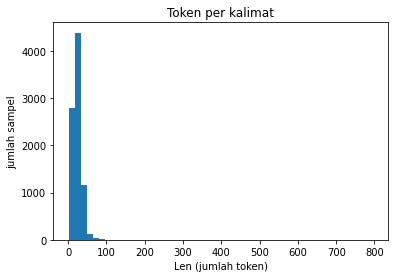

In [ ]:
# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per kalimat')
plt.xlabel('Len (jumlah token)')
plt.ylabel('jumlah sampel')
plt.show()

In [ ]:
class SentenceGetter2(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [w for w in s["Words"].values.tolist()]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter2 = SentenceGetter2(data)
sent = getter2.get_next()
print(sent)

sentences2 = getter2.sentences

['There', "'", 's', 'no', 'denying', 'it', ',', 'Budapest', 'is', 'one', 'of', 'Europe', "'", 's', 'most', 'underrated', 'cities', '.']


In [ ]:
import gensim
model_w2v = gensim.models.Word2Vec(sentences=sentences2, size=100, window=10, 
                                   min_count=1, sg=1, seed=1) #sg= 1:skip-gram 0:cbow
vocab_words = list(model_w2v.wv.vocab)                                                                      
print(len(vocab_words))

17137


In [ ]:
model_w2v.most_similar('Temple')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Fort', 0.934738278388977),
 ('Centre', 0.9346199035644531),
 ('Art', 0.9230125546455383),
 ('Memorial', 0.9206249713897705),
 ('Monument', 0.9196329116821289),
 ('Mughal', 0.9083647727966309),
 ('Palace', 0.8996706008911133),
 ('Place', 0.899570107460022),
 ('Gallery', 0.8951253890991211),
 ('Al', 0.8914657831192017)]

In [ ]:
filename = "w2vskipgram.txt"
model_w2v.wv.save_word2vec_format(filename, binary=False)

In [ ]:
embedding_index = {}
f = open(os.path.join('', 'w2vskipgram.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

embedding_dim = 100
embedding_matrix = np.zeros((len(word2idx) + 1, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word2idx) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=90,
                            trainable=False)

In [ ]:
def plot_history(histories, key='loss'):
  plt.figure(figsize=(5,5))
  
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
          label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])

In [ ]:
def evaluation(model, X, y):
  loss, acc = model.evaluate(X, y, verbose=0)
  print("Accuracy: %.4f" % acc)
  print("Loss: %.4f" % loss)

  return loss, acc


In [ ]:
def train_model(X, y, n_split, model, model_name, epochs):
  acc_results = []
  loss_results = []
  f1_results = []
  skf = StratifiedKFold(n_split, shuffle=True, random_state=1)

  for i, (train, test) in enumerate(skf.split(X,y.argmax(1))):
    X_train, X_test = X[train], X[test]
    y_tr, y_te = y[train], y[test]
    y_train = to_categorical(y_tr, dtype ="uint8") 
    y_test = train_labels = to_categorical(y_te, dtype ="uint8") 

    history = model.fit(X_train, y_train, epochs=epochs, 
                         validation_split=0.2, 
                         batch_size=32)
    loss, acc = evaluation(model, X_test, y_test)
    acc_results.append(acc)
    loss_results.append(loss)

    idx2tag = {i: w for w, i in tag2idx.items()}

    def pred2label(pred):
        out = []
        for pred_i in pred:
            out_i = []
            for p in pred_i:
                p_i = np.argmax(p)
                out_i.append(idx2tag[p_i].replace("0", "O"))
            out.append(out_i)
        return out

    test_pred = model.predict(X_test, verbose=1)
    pred_labels = pred2label(test_pred)
    test_labels = pred2label(y_test)


    print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
    print(classification_report(test_labels, pred_labels))

    f1 = f1_score(test_labels, pred_labels)
    f1_results.append(f1)

    plot_history([('Model', history)])
    filename = model_name
    the_path = os.path.join(file_path, 'TUGAS AKHIR - MODEL', filename+'.h5')
    model.save(the_path)

    #Save the model
    #model to JSON
    model_json = model.to_json()
    with open("adam - no act 50 ep 2.json", "w") as json_file:
        json_file.write(model_json)
    #weights to HDF5
    model.save_weights("adam - no act 50 ep 2.h5")
    print("Saved model to disk")

  acc_avg = round(np.mean(acc_results), 4)
  acc_std = round(np.std(acc_results), 4)
  loss_avg = round(np.mean(loss_results), 4)
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: %.4f (+/- %.4f) ' % (acc_avg, acc_std))
  print(f'> Loss: %.4f' %loss_avg)
  f1_avg = np.mean(f1_results)
  print("> F1 Score: {:.2%}".format(f1_avg))
  print('------------------------------------------------------------------------')

  return acc_avg, acc_std, loss_avg

In [ ]:
def blstmcrf():
  
  model = Sequential()
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(units=128, activation="tanh", return_sequences=True,
                              dropout=0.5)))
  model.add(TimeDistributed(Dense(n_tags)))
  crf_layer = CRF(n_tags, test_mode='viterbi')
  model.add(crf_layer)

  print(model.summary())
  adam = Adam(lr=0.001)
  model.compile(optimizer=adam, loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
  return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 100)           1713800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 90, 256)           234496    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 7)             1799      
_________________________________________________________________
crf_1 (CRF)                  (None, 90, 7)             119       
Total params: 1,950,214
Trainable params: 236,414
Non-trainable params: 1,713,800
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Train on 6120 samples, validate on 1530 samples
Epoch 1/50
6120/6120 [==============================] - 81s 13ms/step - loss: 0.1784 - crf_viterbi_accuracy: 0.9541 - val_loss: 0.0684 - val_crf_viterbi_accuracy: 0.9857
Epoch 2/50
6120/6120 [==============================] - 83s 14ms/step - loss: 0.0655 - crf_viterbi_accuracy: 0.9852 - val_loss: 0.0597 - val_crf_viterbi_accuracy: 0.9856
Epoch 3/50
6120/6120 [==============================] - 79s 13ms/step - loss: 0.0558 - crf_viterbi_accuracy: 0.9856 - val_loss: 0.0524 - val_crf_viterbi_accuracy: 0.9856
Epoch 4/50
6120/6120 [==============================] - 82s 13ms/step - loss: 0.0486 - crf_viterbi_accuracy: 0.9861 - val_loss: 0.0455 - val_crf_viterbi_accuracy: 0.9862
Epoch 5/50
6120/6120 [==============================] - 81s 13ms/step - loss: 0.0425 - crf_viterbi_accuracy: 0.9864 - val_loss: 0.0399 - val_crf_viterbi_accuracy: 0.9864
Epoch 6/50
6120/6120 [==============================] - 86s 14ms/step - loss: 0.0365 - crf_viterbi_acc

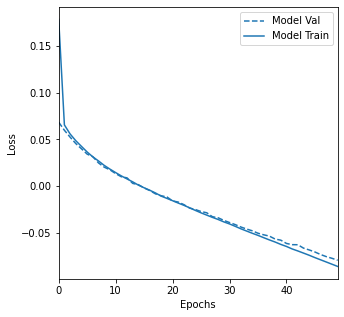

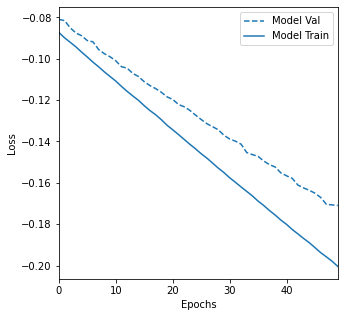

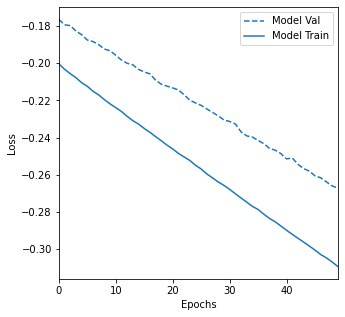

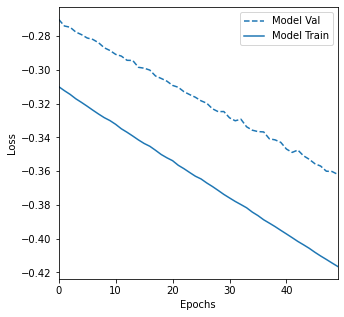

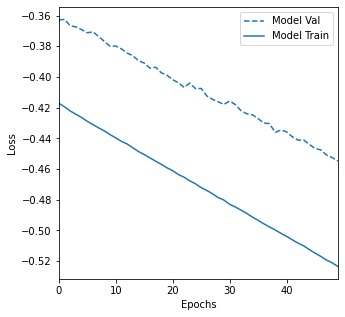

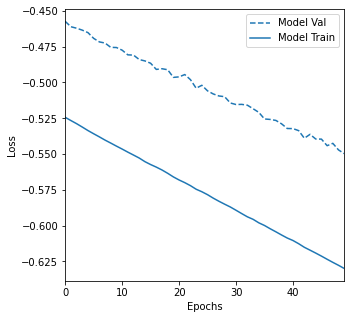

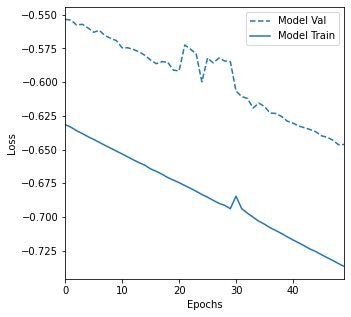

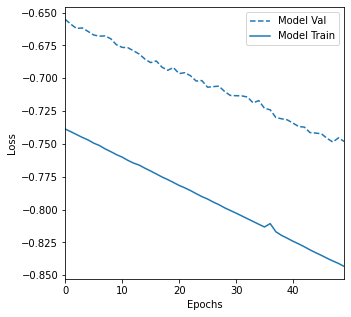

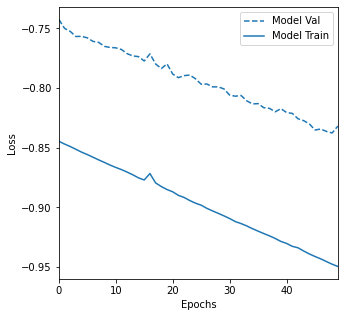

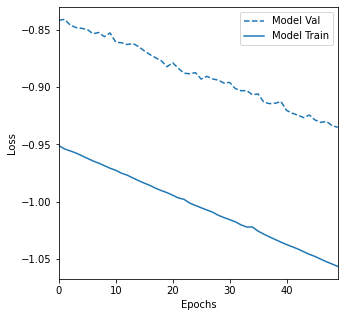

In [ ]:
modelname = 'adam- no act 50 ep 2 drive'
blstmcrf_result = train_model(X, y, 
                              n_split=10, 
                              model=blstmcrf(), 
                              model_name=modelname, 
                              epochs=50)